# Chapter 15. Regression Analysis

여러 dataset 간의 관계를 설명하는 공식이 존재한다는 가설을 세우고 data 에 대충 맞는 coefficient 를 찾아내어 거기에서 차이나는 편차는 noise 로 간주할 수 있다는 가정하에 작동하는 공식을 만들어 타당성을 분석한다.
이러한 모델을 만들 때에는 종속변수를 완벽히 예측할 수 없다는 것을 인정해야 한다. 이제 model 에 적용한 regression coefficient 가 얼마나 안정적인지 즉, data 가 바뀌어도 얼나마 잘 들어 맞는지 평가해 보자. 

In [26]:
import numpy as np
import pandas as pd
from statsmodels import regression, stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp

def linreg(X,Y):
    # Running the linear regression
    x = sm.add_constant(X) # Add a row of 1's so that our model has a constant term
    model = regression.linear_model.OLS(Y, x).fit()
    return model.params[0], model.params[1] # Return the coefficients of the linear model

# 편향된 잡음 (Biased noise)

여기서 볼 것은 noise 가 균등 분포되어 있지 않으면 부정확한 모델이 나올 수 있다. 아래의 예제 경우 표본의 수가 몇개 안되어 alpha 가 -0.4 로 나와 버려야할 모델처럼 보이는데, data 를 더 많이 만들면 regression coefficient (intercept)가 0 에 가까워 짐을 볼 수 있다. 이런 경우를 small sample size bias 라고 부른다.

Slope: 0.009072503822685518 Intercept: -0.40207744085303826


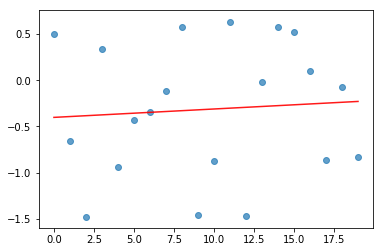

In [27]:
# 정규분포로 부터 측정값을 구함 --> 20 개 noise
np.random.seed(107) # Fix seed for random number generation
rand = np.random.randn(20)    # random noise 20 개

# Conduct linear regression on the ordered list of observations
xs = np.arange(20)
a, b = linreg(xs, rand)
print('Slope:', b, 'Intercept:', a)

# Plot the raw data and the regression line
plt.scatter(xs, rand, alpha=0.7)
Y_hat = xs * b + a
plt.plot(xs, Y_hat, 'r', alpha=0.9);

seaborn 그래프에서 색칠된 부분은 95 신뢰구간을 뜻한다.

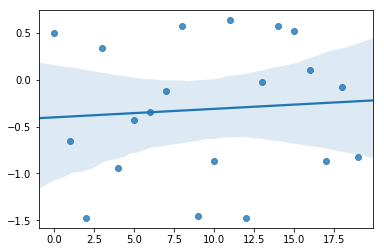

In [28]:
import seaborn

seaborn.regplot(xs, rand);

Slope: -0.0005693423631053367 Intercept: 0.009011767319021837


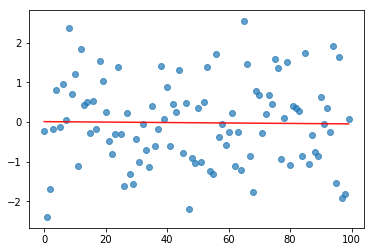

In [29]:
# noise 표본수를 100 개로 증가
rand2 = np.random.randn(100)

# Conduct linear regression on the ordered list of observations
xs2 = np.arange(100)
a2, b2 = linreg(xs2, rand2)
print('Slope:', b2, 'Intercept:', a2)

# Plot the raw data and the regression line
plt.scatter(xs2, rand2, alpha=0.7)
Y_hat2 = xs2 * b2 + a2
plt.plot(xs2, Y_hat2, 'r', alpha=0.9);

Regression 분석은 이상점(outlier) 들에 매우 민감함. 때로 정보를 가진 outlier 도 있으나 위와 같은 경우는 단순히 random noise  일 뿐이다. data 가 더 많아질 경우에도 거기에는 예를 들어 주, 월 순서에 따른 fluctuation 이 있어서 regression coefficient 를 유의성 있게 변화시킬 수 있다.

# Regime changes

regime change 는 structural break 라고도 하며 data 생성 과정에 변화가 생겨 다른 분포를 만들 때를 뜻한다. 아래의 예는 2007 년 말에 regime change 가 있어서 전체 data set 을 regression 하는 것보다 data 를 쪼개는 것이 더 잘 맞는 경우를 보여준다. 이런 경우 기저에 깔린 시스템이 변하였으므로 model 이 regime change 이후의 data 에는 더 이상 predictive 하지 못한다. regression analysis 는 error 들의 상관관계가 없고 일정한 variance 를 가지고 있다고 가정하는데, regime change 가 있으면 이러한 가정도 유효하지 못하다.

따라서, 주식 시장에 공식을 적용할 때는 간단한 test 를 매번 수행해 주어 regime change 여부를 검증해야 한다.

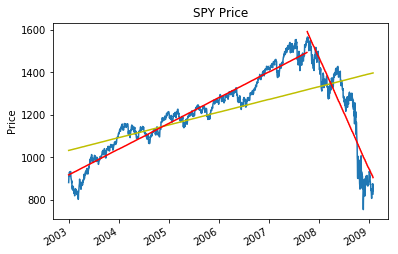

In [47]:
from googlefinance.client import get_price_data, get_prices_data
import pandas as pd

params_INDEX = [{'q': ".INX", 'x': "INDEXSP",}]
period = "20Y"
# get open, high, low, close, volume data (return pandas dataframe)
df = get_prices_data(params_INDEX , period)
df.index = pd.to_datetime(df.index)

start = pd.to_datetime('2003-01-01')
end = pd.to_datetime('2009-02-01')
# get price data (return pandas dataframe)
pricing = df['.INX_Close'].loc[start:end]

# Manually set the point where we think a structural break occurs
breakpoint = 1200
xs = np.arange(len(pricing))
xs2 = np.arange(breakpoint)
xs3 = np.arange(len(pricing) - breakpoint)

# Perform linear regressions on the full data set, the data up to the breakpoint, and the data after
a, b = linreg(xs, pricing)
a2, b2 = linreg(xs2, pricing[:breakpoint])
a3, b3 = linreg(xs3, pricing[breakpoint:])

Y_hat = pd.Series(xs * b + a, index=pricing.index)
Y_hat2 = pd.Series(xs2 * b2 + a2, index=pricing.index[:breakpoint])
Y_hat3 = pd.Series(xs3 * b3 + a3, index=pricing.index[breakpoint:])

# Plot the raw data
pricing.plot()
Y_hat.plot(color='y')
Y_hat2.plot(color='r')
Y_hat3.plot(color='r')
plt.title('SPY Price')
plt.ylabel('Price');

위의 경우 yellow line 보다 regime change 전, 후로 쪼개어 regression 한 model (red line) 이 훨씬 잘 맞는다.

물론 dataset 를 더 잘게 쪼개면 더 정확히 맞겠지만 항상 fluctuate 하고 예측불가능한 noise 에 fitting 하면 안된다. 우리가 인지했거나 일반적인 경우 structural break 의 존재를 test 할 수 있다.  아래에서 `statsmodels` 을 사용하여 data 에 breakpoint 가 포함되어 있는지 test 할 수 있다.

breaks_cusumolsresid (cumulative sum test for parameter stability based on ols residuals) :
귀무가설은 no structural change 이다. 아래의 경우 pvalue 가 0.05 보다 작으므로 pricing dataset 에 structural change 가 있었다.

In [46]:
stats.diagnostic.breaks_cusumolsresid(
    regression.linear_model.OLS(pricing, sm.add_constant(xs)).fit().resid)[1]

4.770245087576516e-59

# 다중 공선성 (Multicollinearity)

아래는 이전 chapter 에서 보았던 상호관계를 가진 변수들로 이루어진 multiple linear regression 이다. sample 기간을 2013-01-01 에서 2015-01-01 로 할 겨우 coefficients 는 약 .25 and .1 인데, 기간을 2015-06-01 로 늘리면 coefficients 는 대략 .18 and .20 가 된다.

Constant: -16.266842792368333 MLR beta to S&P 500: 0.038463983103026796  MLR beta to MDY -0.027510488850925847


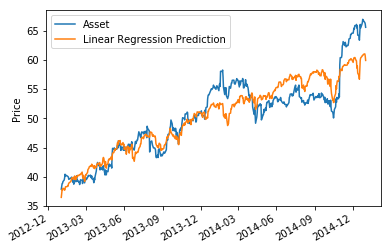

In [58]:
# Get pricing data for two benchmarks (stock indices) and a stock
start = pd.to_datetime('2013-01-01')
end = pd.to_datetime('2015-01-01')

params_INDEX = [{'q': ".INX", 'x': "INDEXSP",}]
period = "20Y"   # from today
df = get_prices_data(params_INDEX , period)
df.index = pd.to_datetime(df.index)

b1 = df['.INX_Close'].loc[start:end]

param_STOCK = {'q': "AAPL", 'i': "86400", 'x': "NASD", 'p': "20Y" }
df = pd.DataFrame(get_price_data(param_STOCK))
df.index = df.index.date
df.index = pd.to_datetime(df.index)
b2 = df['Close'].loc[start : end]

param_STOCK = {'q': "V", 'i': "86400", 'x': "NYSE", 'p': "10Y" }
df = pd.DataFrame(get_price_data(param_STOCK))
df.index = df.index.date
df.index = pd.to_datetime(df.index)

asset = df['Close'].loc[start : end]

mlr = regression.linear_model.OLS(asset, sm.add_constant(np.column_stack((b1, b2)))).fit()
prediction = mlr.params[0] + mlr.params[1]*b1 + mlr.params[2]*b2
print('Constant:', mlr.params[0], 'MLR beta to S&P 500:', mlr.params[1], ' MLR beta to MDY', mlr.params[2])

# Plot the asset pricing data and the regression model prediction, just for fun
asset.plot()
prediction.plot();
plt.ylabel('Price')
plt.legend(['Asset', 'Linear Regression Prediction']);

Constant: -13.548948360436807 MLR beta to S&P 500: 0.03110101338357712  MLR beta to MDY 0.10836320961335608


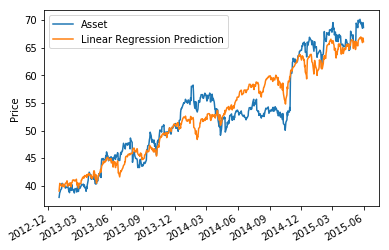

In [60]:
# Get pricing data for two benchmarks (stock indices) and a stock
start = pd.to_datetime('2013-01-01')
end = pd.to_datetime('2015-06-01')

params_INDEX = [{'q': ".INX", 'x': "INDEXSP",}]
period = "20Y"   # from today
df = get_prices_data(params_INDEX , period)
df.index = pd.to_datetime(df.index)

b1 = df['.INX_Close'].loc[start:end]

param_STOCK = {'q': "AAPL", 'i': "86400", 'x': "NASD", 'p': "20Y" }
df = pd.DataFrame(get_price_data(param_STOCK))
df.index = df.index.date
df.index = pd.to_datetime(df.index)
b2 = df['Close'].loc[start : end]

param_STOCK = {'q': "V", 'i': "86400", 'x': "NYSE", 'p': "10Y" }
df = pd.DataFrame(get_price_data(param_STOCK))
df.index = df.index.date
df.index = pd.to_datetime(df.index)

asset = df['Close'].loc[start : end]

mlr = regression.linear_model.OLS(asset, sm.add_constant(np.column_stack((b1, b2)))).fit()
prediction = mlr.params[0] + mlr.params[1]*b1 + mlr.params[2]*b2
print('Constant:', mlr.params[0], 'MLR beta to S&P 500:', mlr.params[1], ' MLR beta to MDY', mlr.params[2])

# Plot the asset pricing data and the regression model prediction, just for fun
asset.plot()
prediction.plot();
plt.ylabel('Price')
plt.legend(['Asset', 'Linear Regression Prediction']);

correlation coefficient 를 계산하여, 독립변수들이 correlate 되어 있음을 알 수 있다. 숫자들은 항상 -1 에서 1 사이이고 1 인 경우 두 변수들은 완전히 correlated 되어 있음을 뜻한다.

In [62]:
# Compute Pearson correlation coefficient
sp.stats.pearsonr(b1,b2)[0] # Second return value is p-value

0.9127100011050878